In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import sys
import os
import math
warnings.filterwarnings('ignore')
 
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt 
import pprint

import tkinter as tk    # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename

import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
from IPython.display import clear_output
import IPython
import pylab
pylab.rcParams['figure.figsize'] = (16, 8)
width, height = pylab.rcParams['figure.figsize']

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [66]:
def plot_pyplot(battery_id, data):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,15))

    for index in range(len(data[battery_id]['cell_temperature'][0])):
        axs[0].plot(data[battery_id]['timestamp']/1000, data[battery_id]['cell_voltage'][:,index], label="Cell {}.{}".format(battery_id+1, index+1))
        axs[1].plot(data[battery_id]['timestamp']/1000, data[battery_id]['cell_temperature'][:,index], label="Cell {}.{}".format(battery_id+1, index+1))

    axs[0].set_ylabel('Voltage [V]')
    axs[0].grid(True)
    axs[0].legend()
    axs[1].set_ylabel('Temperateu [°C]')
    axs[1].grid(True)
    axs[1].set_xlabel('Time [s]')
    axs[1].legend()
    axs[1].set_xlim([np.min(data[battery_id]['timestamp']/1000), np.max(data[battery_id]['timestamp']/1000)])
    fig.tight_layout()
    fig.show()

In [67]:
def plot_plotly(battery_id, data):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,vertical_spacing=0.01, subplot_titles=("Battery %d" % (battery_id+1), ""))
    
    for index in range(len(data[battery_id]['cell_voltage'][0])):
        fig.append_trace(go.Scatter(x=data[battery_id]['timestamp']/1000,y= data[battery_id]['cell_voltage'][:,index], mode='lines', name="Volt. {}.{}".format(battery_id+1, index+1)), row=1, col=1)
    for index in range(len(data[battery_id]['cell_temperature'][0])):
        fig.append_trace(go.Scatter(x=data[battery_id]['timestamp']/1000,y= data[battery_id]['cell_temperature'][:,index], mode='lines', name="Temp. {}.{}".format(battery_id+1, index+1)), row=2, col=1)

    fig.update_layout(width=15*60, height=5*120)
    fig.show()

[Info] Open: test_06cf.csv test_06vicon.csv


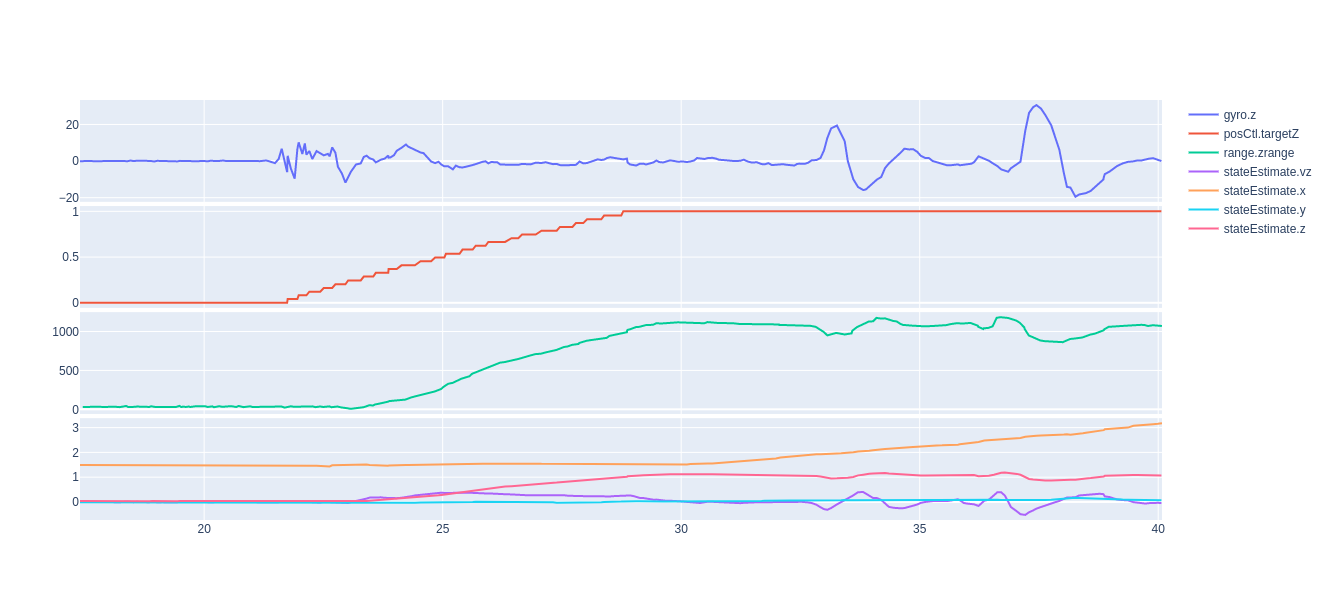

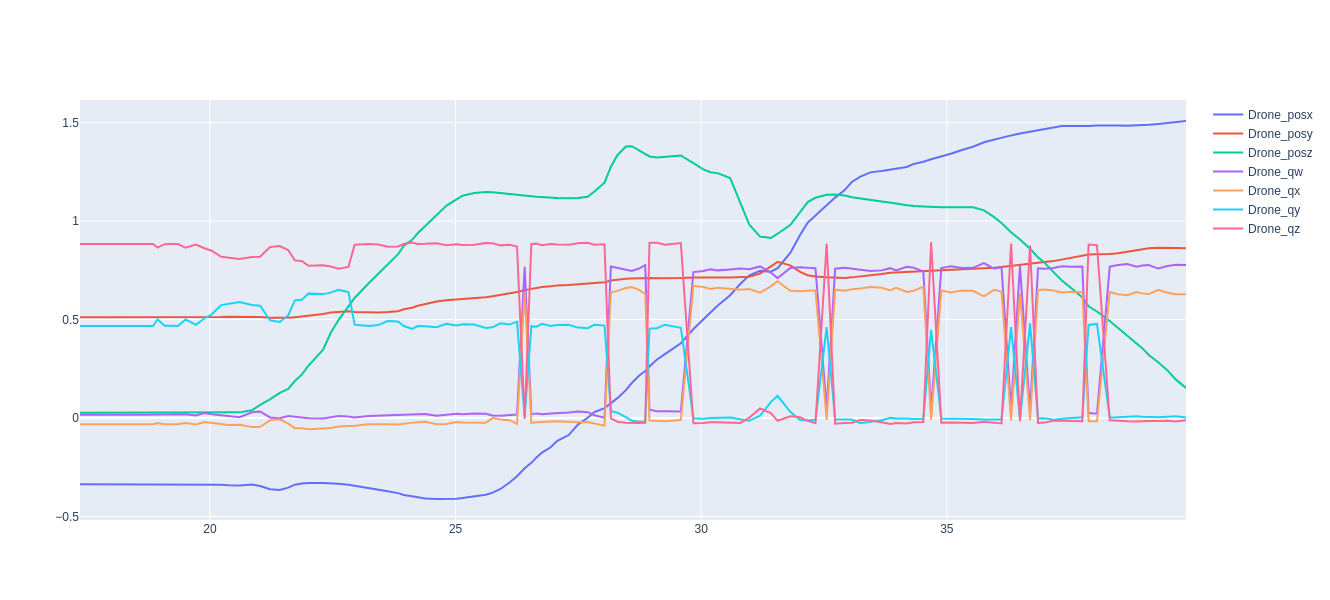

In [183]:
path_cf    = os.path.join("logs", "test_06cf.csv")
path_vicon = os.path.join("logs", "test_06vicon.csv")
print("[Info] Open:", os.path.basename(path_cf), os.path.basename(path_vicon))

import pandas as pd

df = pd.read_csv(path_cf, header=0, names=["Timestamp", "ID", "Value"])

keys = []
for key in np.unique(df["ID"]):
    keys.append(key.split(".")[0])
keys = np.unique(keys)

n_groups = len(keys)
fig = make_subplots(rows=n_groups, cols=1, shared_xaxes=True,vertical_spacing=0.01)

for k, group in df.groupby(["ID"]):
    key = group.iloc[0,1].split(".")[0]
    group_index = np.where(keys == key)[0][0]
    fig.append_trace(go.Scatter(x=group['Timestamp']/1000, y= group['Value'], mode='lines', name="{}".format(group.iloc[0,1])), row=group_index+1, col=1)

fig.update_layout(width=15*60, height=5*120)
fig.show()

df = pd.read_csv(path_vicon, header=0, names=["Timestamp", "ID", "Value"])

keys = []
for key in np.unique(df["ID"]):
    t = key.split("_")[0]
    if t != "Box": 
        keys.append(t)
        
keys = np.unique(keys)

n_groups = len(keys)
fig = make_subplots(rows=n_groups, cols=1, shared_xaxes=True,vertical_spacing=0.01)

for k, group in df.groupby(["ID"]):
    key = group.iloc[0,1].split("_")[0]
    group_index = np.where(keys == key)[0]
    if group_index >= 0:
        fig.append_trace(go.Scatter(x=group['Timestamp']/1000, y= group['Value'], mode='lines', name="{}".format(group.iloc[0,1])), row=int(group_index)+1, col=1)

fig.update_layout(width=15*60, height=5*120)
fig.show()

In [206]:
import pandas as pd
from scipy.stats import linregress

FILE = "algo02cf.csv"
# read the CSV file
path_cf    = os.path.join("logs", FILE)
print("[Info] Open:", os.path.basename(path_cf), os.path.basename(path_vicon))

df = pd.read_csv(path_cf, header=0, names=["Timestamp", "ID", "Value"])

# extract the time-of-flight sensor value
for k, group in df.groupby(["ID"]):
    if k == "range.zrange":
        rangez_data = group.reset_index()
        rangez_data = pd.DataFrame(rangez_data[["Timestamp", "Value"]])
    if k == "range.zslope":
        slopez_data = group.reset_index()
        slopez_data = pd.DataFrame(slopez_data[["Timestamp", "Value"]])
    if k == "range.zoffset":
        zoffset_data = group.reset_index()
        zoffset_data = pd.DataFrame(zoffset_data[["Timestamp", "Value"]])
    if k == "posCtl.targetZ":
        targetZ_data = group.reset_index()
        targetZ_data = pd.DataFrame(targetZ_data[["Timestamp", "Value"]])
        
        
# differentiate and add to the dataframe
dT = (np.diff(rangez_data["Timestamp"]) / 1000)
dValue = np.diff(rangez_data["Value"]) / dT
dT = np.insert(dT, 0, 0)
dValue = np.insert(dValue, 0, 0)
#rangez_data["dT"] = dT
rangez_data["dValue"] = dValue
n_median = 5
dValue_median = [np.median(dValue[max(0, current - n_median): current]) for current in range(0, len(dValue))]
rangez_data["dValue_median"] = dValue_median
n_linreg = 5
dValue_linreg = [0]

for current in range(1, len(dValue)):
    x = rangez_data["Timestamp"][max(0, current - n_linreg) : current] / 1000
    y = rangez_data["Value"][max(0, current - n_linreg) : current]
    slope = linregress(x, y)[0]
    dValue_linreg = np.append(dValue_linreg, slope)
rangez_data["dValue_linreg"] = dValue_linreg


fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)


fig.append_trace(go.Scatter(x=zoffset_data["Timestamp"]/1000, y= zoffset_data["Value"]*1000,
                            mode="lines", name="Value"), row = 1, col = 1)
fig.append_trace(go.Scatter(x=targetZ_data["Timestamp"]/1000, y= targetZ_data["Value"]*1000,
                            mode="lines", name="Value"), row = 1, col = 1)
fig.append_trace(go.Scatter(x=rangez_data["Timestamp"]/1000, y= rangez_data["Value"],
                            mode="lines", name="Setpoint Z"), row = 1, col = 1)
fig.append_trace(go.Scatter(x=rangez_data["Timestamp"]/1000, y= rangez_data["dValue"],
                            mode="lines", name="dValue"), row = 2, col = 1)
fig.append_trace(go.Scatter(x=rangez_data["Timestamp"]/1000, y= rangez_data["dValue_median"],
                            mode="lines", name="dValue_median"), row = 3, col = 1)
#fig.append_trace(go.Scatter(x=rangez_data["Timestamp"]/1000, y= rangez_data["dT"], mode="lines", name="dT"),
#                 row = 4, col = 1)
fig.append_trace(go.Scatter(x=rangez_data["Timestamp"]/1000, y= rangez_data["dValue_linreg"],
                            mode="lines", name="dValue_linreg"), row = 3, col = 1)
fig.append_trace(go.Scatter(x=slopez_data["Timestamp"]/1000, y= slopez_data["Value"]*1000,
                            mode="lines", name="zSlope"), row = 3, col = 1)
fig.show()

[Info] Open: algo02cf.csv test_06vicon.csv


NameError: name 'zoffset_data' is not defined